In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import timeit
import seaborn as sns


#these are user defined modules
import plot
import calculate

### Cumulative Advantage

For each (filtered) cohort analyze how the distribution of publications changes in the cohort over time.
At the beginning all scientists should be equal (they have zero publications). Over time some scientists become more successful than others which leads to an increase in the Gini coefficient.

In [2]:
start_time = timeit.default_timer()
print(start_time)

1509028727.31


### Read Gender details

In [3]:
# read gender details - the column names are name, gender - change it to author, gender
gender = pd.read_csv('./data/name_gender_1970_2016_noAsians.csv')
gender.rename(columns={'name':'author'}, inplace=True)
print(gender.head())
print(gender['gender'].unique())
print(gender['author'].nunique())

             author gender
0    nima mesgarani      m
1    james j. abbas      m
2  eberhart zrenner      m
3    emery n. brown      m
4        ilya rybak      m
['m' 'none' 'f']
1129473


### Read and make a list of credible authors - authors whose career span is atleast 15 years

In [4]:
max_years = 15
#authorStartEndCareerData = pd.read_csv('data/authors-scientific-start-end-year-publish-count.csv')
authorStartEndCareerData = pd.read_csv('data/authors-scientific-atleast-15-year.csv')
#authorStartEndCareerData = pd.read_csv('data/authors-scientific-atleast-20-year-20-papers.csv')
print(authorStartEndCareerData.head())

print("authorStartEndCareerData  %s", authorStartEndCareerData.shape[0])
print("author unique names  %s", authorStartEndCareerData['author'].nunique())
print(authorStartEndCareerData[authorStartEndCareerData['author']=='a min tjoa'])

               author  start_year  end_year  pub_count  career_length
0          a min tjoa        1979      2015        193             36
1    a-imam al-sammak        1992      2008          6             16
2          a-xing zhu        1998      2015         16             17
3  a. a. (louis) beex        1980      2016         34             36
4     a. a. a. nasser        1993      2014          3             21
('authorStartEndCareerData  %s', 110888)
('author unique names  %s', 110888)
       author  start_year  end_year  pub_count  career_length
0  a min tjoa        1979      2015        193             36


### Merge credible authors and their gender information

In [5]:
authorStartEndCareerData = pd.merge(authorStartEndCareerData, gender, how="left", on=["author"])
# for authors whose gender not found, replace it with none
authorStartEndCareerData['gender'] = authorStartEndCareerData['gender'].fillna('none')
print(authorStartEndCareerData.head())
print("authorStartEndCareerData with duplicates: %s", authorStartEndCareerData.shape[0])

# there are no duplicates
authorStartEndCareerData = authorStartEndCareerData.drop_duplicates()
print("authorStartEndCareerData no duplicates: %s", authorStartEndCareerData.shape[0])
print(authorStartEndCareerData['author'].nunique())

#axes = authorStartEndCareerData.boxplot(column='pub_count', by='gender', return_type='axes')
#for ax in axes.values():
#    ax.set_ylim(0, 200)
#plt.show()

             author  start_year  end_year  pub_count  career_length gender
0        a min tjoa        1979      2015        193             36   none
1  a-imam al-sammak        1992      2008          6             16      m
2  a-imam al-sammak        1992      2008          6             16      m
3  a-imam al-sammak        1992      2008          6             16      m
4  a-imam al-sammak        1992      2008          6             16      m
('authorStartEndCareerData with duplicates: %s', 2368899)
('authorStartEndCareerData no duplicates: %s', 110888)
110888


In [6]:
authorCitationsData = pd.read_csv('./data/authors_cite_2016_asiansAsNone.txt')
#id1 represents the author who cited
#id2 is the author who has been cited by id1 in year Y
authorCitationsData.rename(columns={'id2':'author'}, inplace=True)
print(authorCitationsData.head())

#Group by both year and author - multi index and hierarchial indexing
groupCitationsByAuthorYearData = authorCitationsData.groupby(['year','author']).count().reset_index()
groupCitationsByAuthorYearData.rename(columns={'id1':'count'}, inplace=True)

#remove wrong data
groupCitationsByAuthorYearData = groupCitationsByAuthorYearData[groupCitationsByAuthorYearData["year"] > 1900]
print(groupCitationsByAuthorYearData.head())
print(groupCitationsByAuthorYearData[groupCitationsByAuthorYearData.author=="a min tjoa"])

              id1        author  year
0   stefano rizzi    qiong fang  2006
1   stefano rizzi  jianlin feng  2006
2   stefano rizzi    hulin ding  2006
3  alberto abelló    qiong fang  2006
4  alberto abelló  jianlin feng  2006
   year             author  count
0  1957         bush jones      1
1  1959  a. s. householder      1
2  1959    donald l. shell      1
3  1961     alan j. perlis      1
4  1961    calvin c. elgot      1
        year      author  count
106948  2007  a min tjoa      8
181492  2010  a min tjoa      2
284350  2013  a min tjoa      9


### Merge Citations with credible authors and their gender information

    year          author  count  start_year  end_year  pub_count  \
0   1957      bush jones      1        1970      1986          4   
10  1961  jack b. dennis      2        1972      2015         33   

    career_length gender  
0              16      m  
10             43      m  
47720
176171
    year              author  count  start_year  end_year  pub_count  \
0   1957          bush jones      1        1970      1986          4   
10  1961      jack b. dennis      2        1972      2015         33   
12  1961         m. e. maron      1        1977      2008         11   
18  1962  friedrich l. bauer      1        1971      2011         91   
20  1962     john mccarthy 1      1        1974      2008         47   

    career_length gender  
0              16      m  
10             43      m  
12             31   none  
18             40      m  
20             34   none  
        year      author  count  start_year  end_year  pub_count  \
106948  2007  a min tjoa      8       

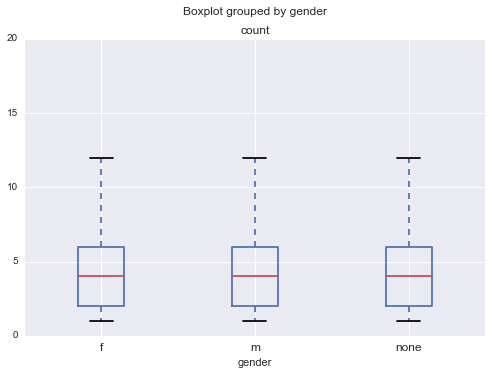

In [7]:
groupCitationsByAuthorYearData = pd.merge(groupCitationsByAuthorYearData, authorStartEndCareerData,  
                                          how="left", left_on="author", right_on="author")

groupCitationsByAuthorYearData = groupCitationsByAuthorYearData.dropna(how='any')
print(groupCitationsByAuthorYearData.head(n=2))
print(groupCitationsByAuthorYearData['author'].nunique())
print(groupCitationsByAuthorYearData.shape[0])

print(groupCitationsByAuthorYearData.head())
print(groupCitationsByAuthorYearData[groupCitationsByAuthorYearData.author=="a min tjoa"])


groupCitationsByAuthorYearData = groupCitationsByAuthorYearData.reset_index()
print(groupCitationsByAuthorYearData.head())

axes = groupCitationsByAuthorYearData.boxplot(column='count', by='gender', return_type='axes')
for ax in axes.values():
    ax.set_ylim(0, 20)
    
plt.show()

In [8]:
# cumulative number of citations per author per year
groupCitationsByAuthorYearData = groupCitationsByAuthorYearData.set_index('year').sort_index()

groupCitationsByAuthorYearData["cum_num_cit"] = groupCitationsByAuthorYearData.groupby(['author'])['count'].transform(pd.Series.cumsum)
groupCitationsByAuthorYearData = groupCitationsByAuthorYearData.reset_index()
print(groupCitationsByAuthorYearData.head())


   year  index              author  count  start_year  end_year  pub_count  \
0  1957      0          bush jones      1        1970      1986          4   
1  1961     10      jack b. dennis      2        1972      2015         33   
2  1961     12         m. e. maron      1        1977      2008         11   
3  1962     18  friedrich l. bauer      1        1971      2011         91   
4  1962     20     john mccarthy 1      1        1974      2008         47   

   career_length gender  cum_num_cit  
0             16      m            1  
1             43      m            2  
2             31   none            1  
3             40      m            1  
4             34   none            1  


In [9]:
# this is for debugging purposes
# when modules are modified, they need to be reloaded in this fashion to get reflected

#reload(plot)
#reload(calculate)

In [10]:
years = authorStartEndCareerData['start_year'].unique() 
years = list(years) + list(authorStartEndCareerData['end_year'].unique())
years = list(set(list(years)))
years = sorted(years)
print(years)
print(type(years))

[1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
<type 'list'>


/usr/local/lib/python2.7/dist-packages/numpy-1.12.0.dev0_5b91628-py2.7-linux-x86_64.egg/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/numpy-1.12.0.dev0_5b91628-py2.7-linux-x86_64.egg/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


       author  start_year  end_year  pub_count  career_length gender
0  a min tjoa        1979      2015        193             36   none


/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


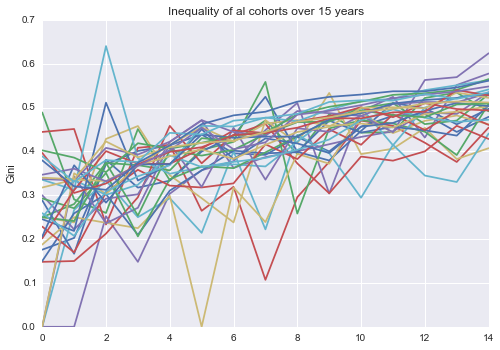

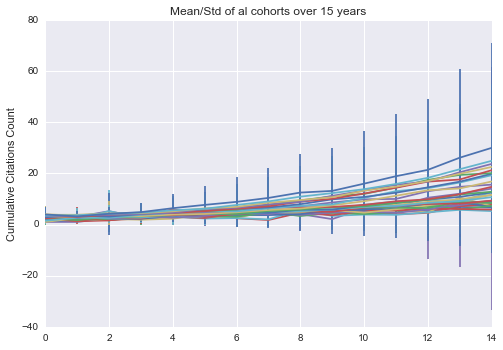

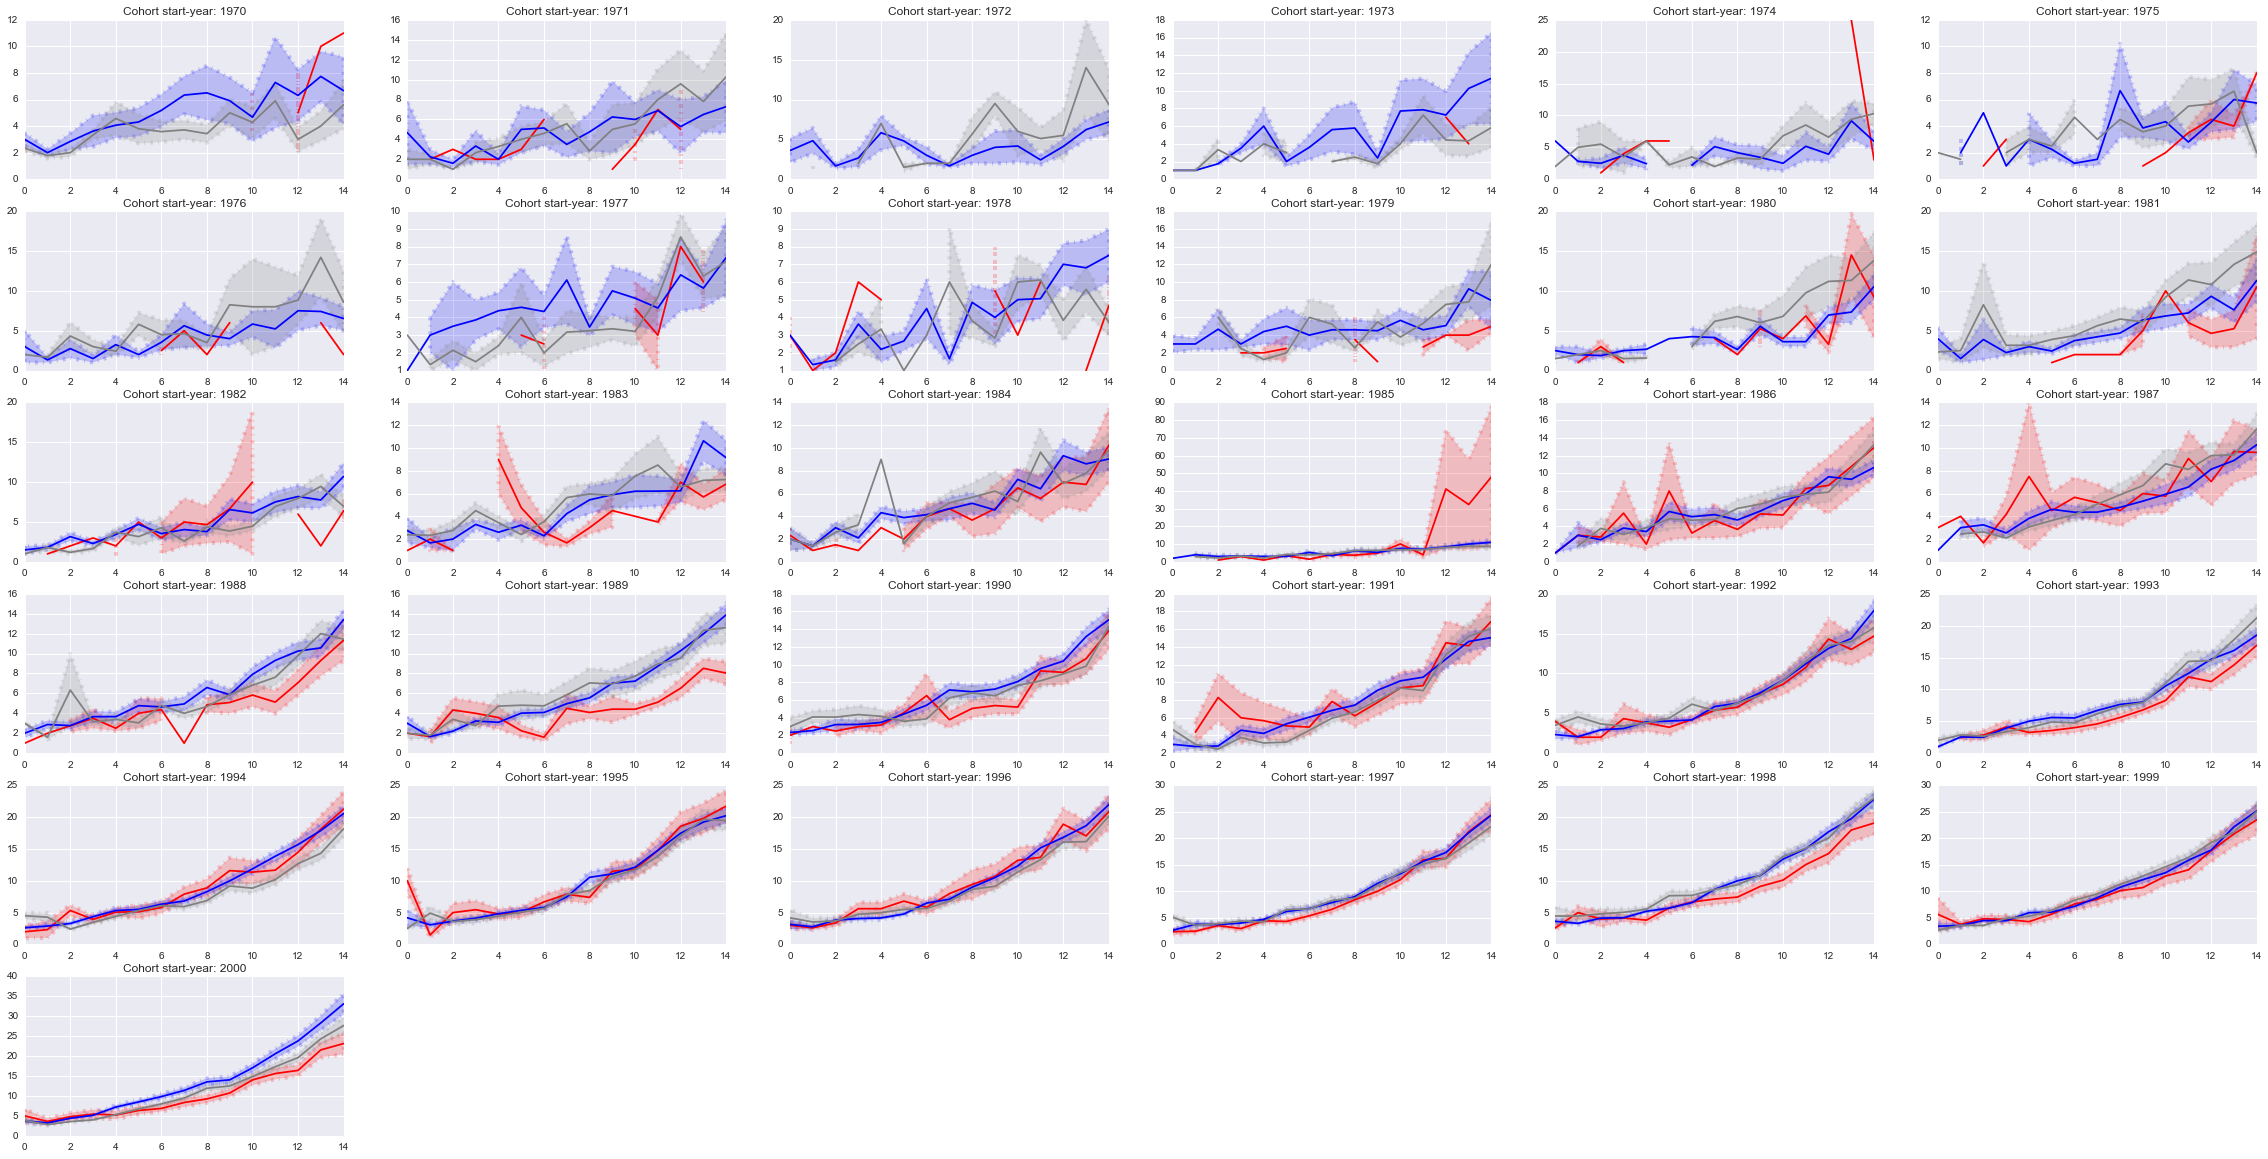

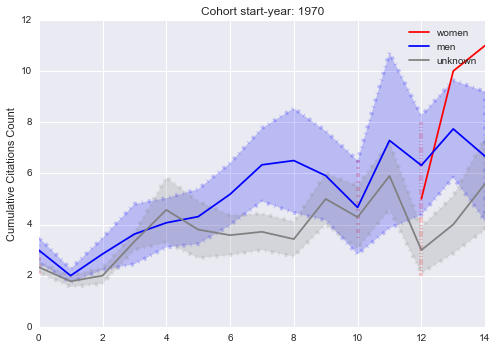

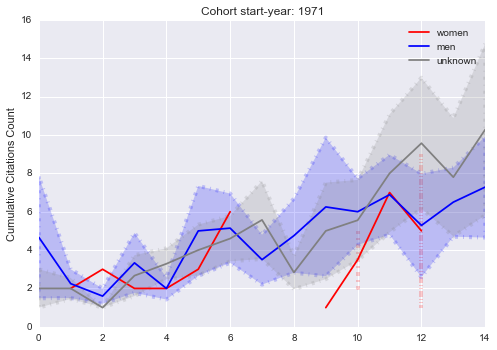

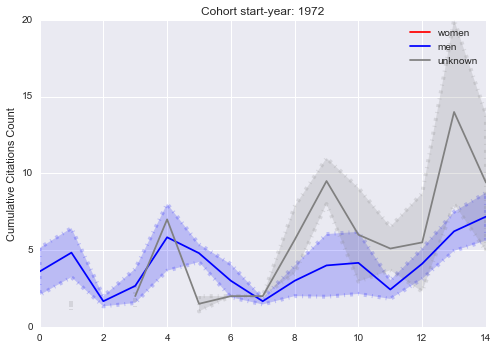

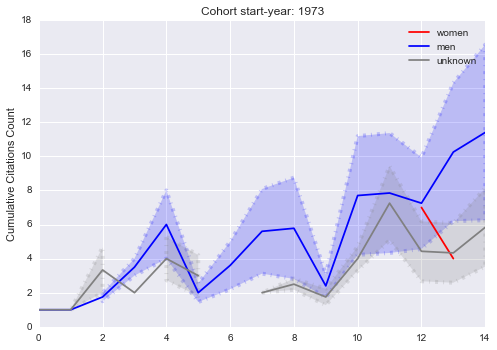

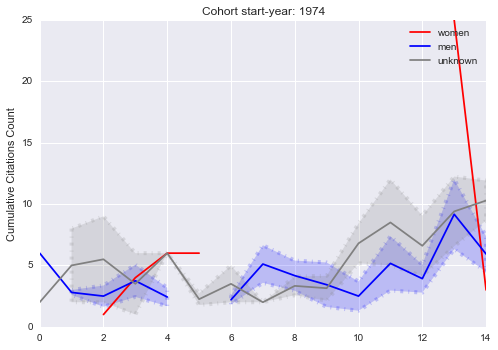

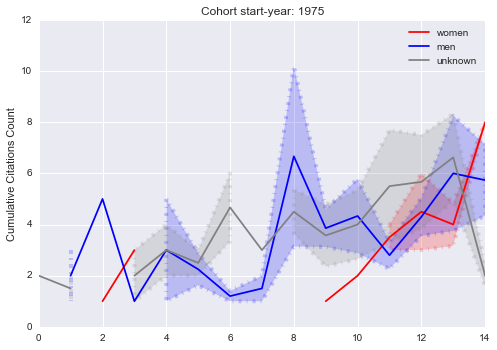

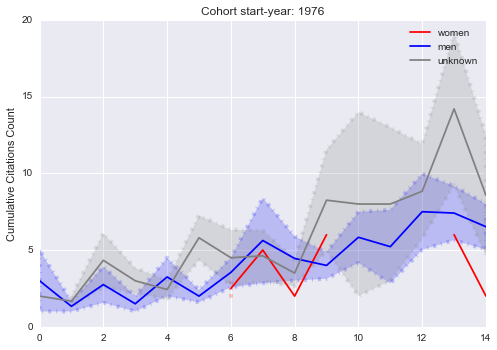

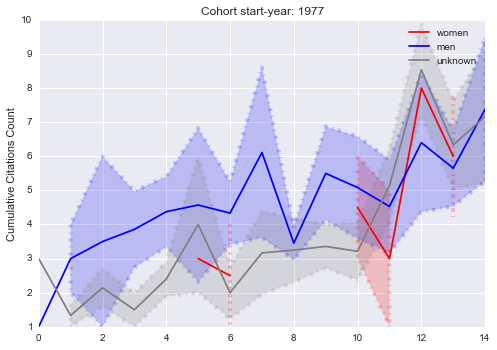

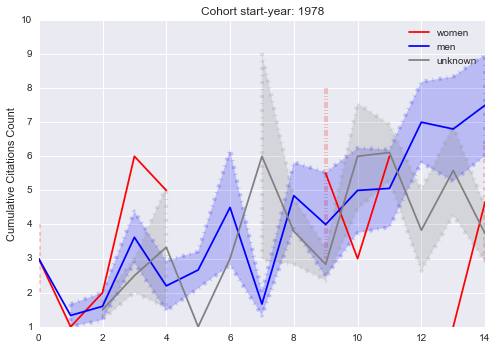

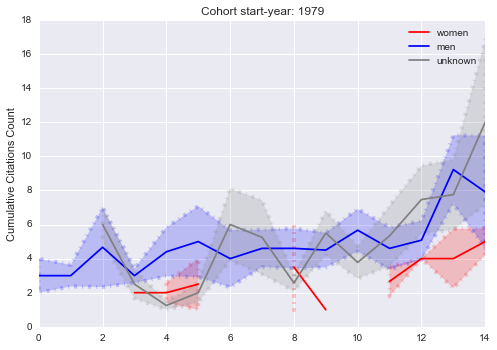

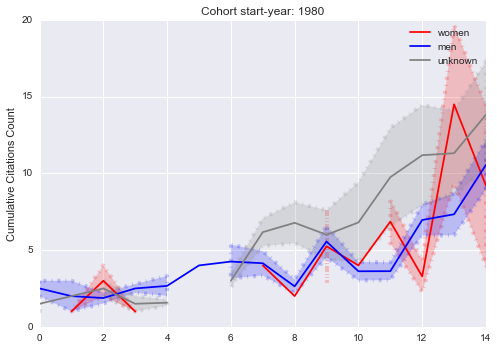

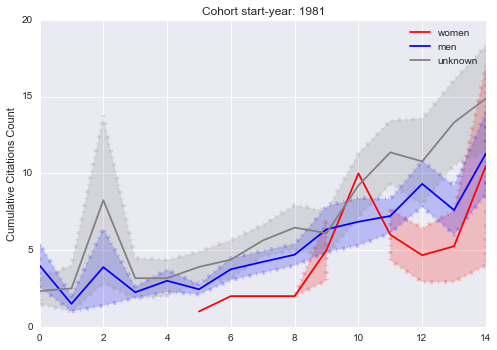

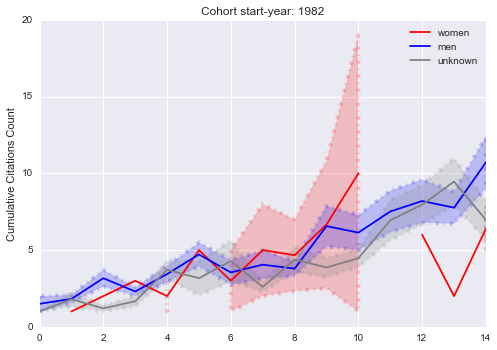

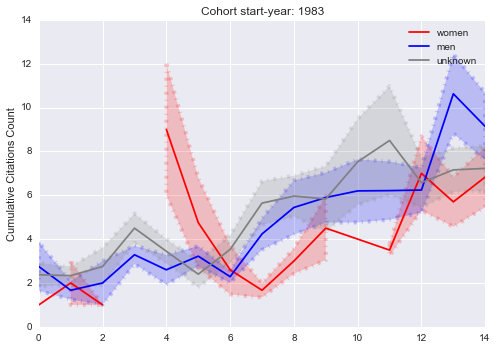

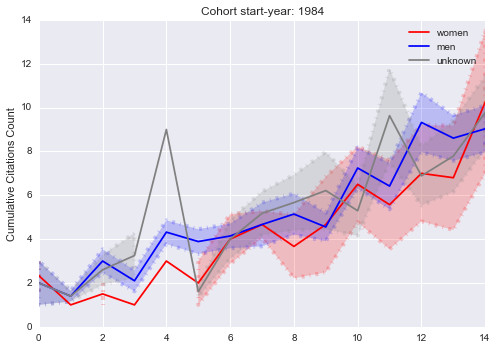

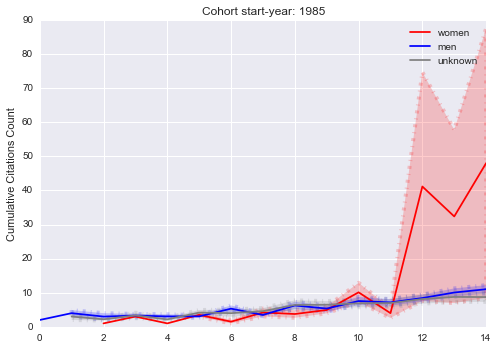

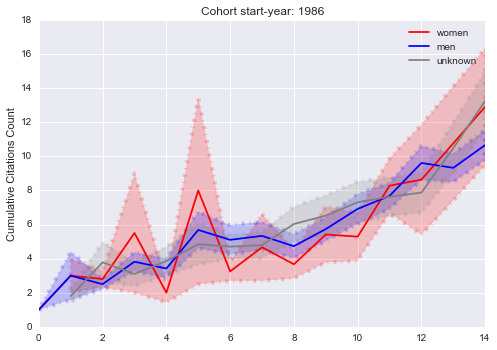

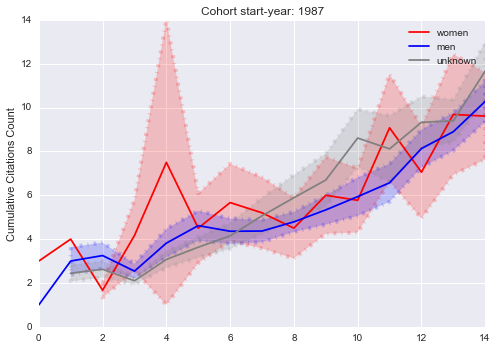

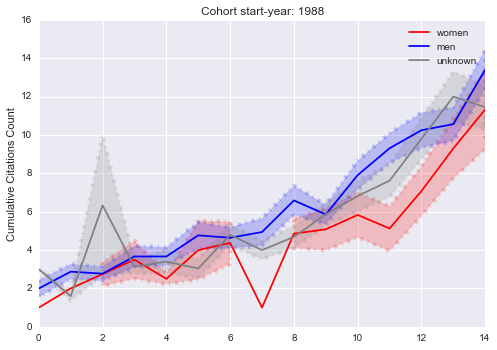

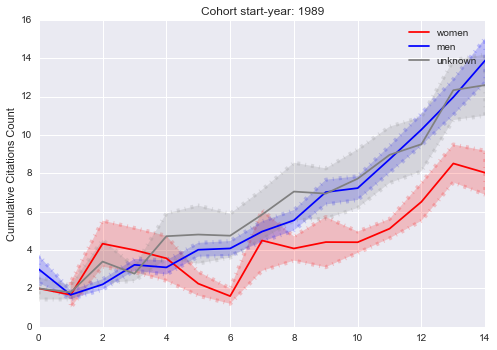

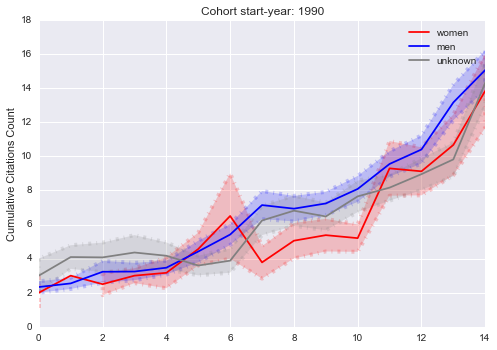

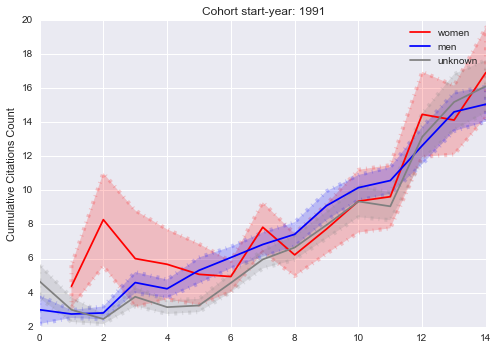

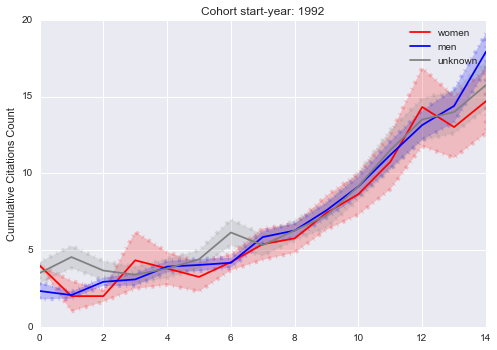

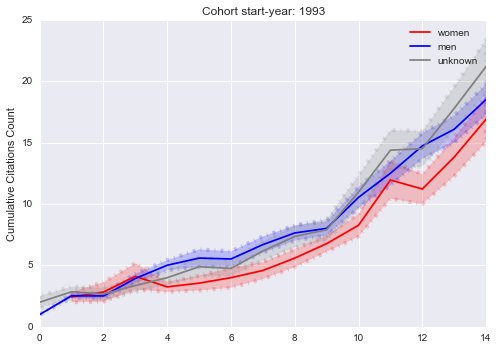

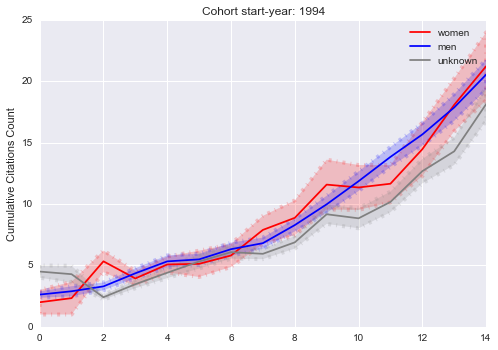

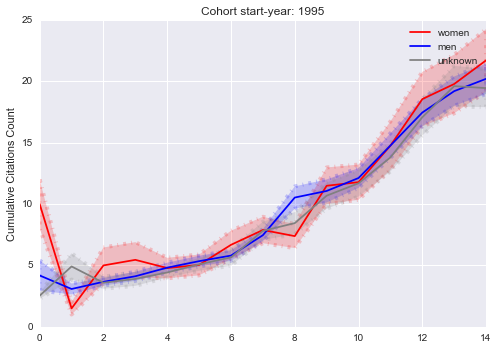

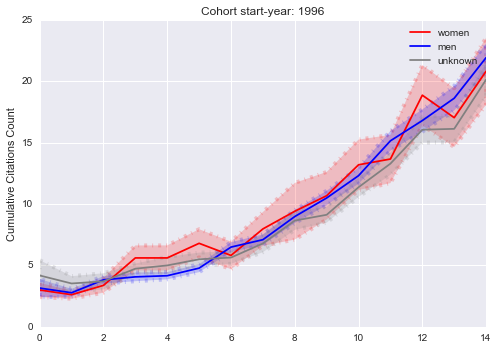

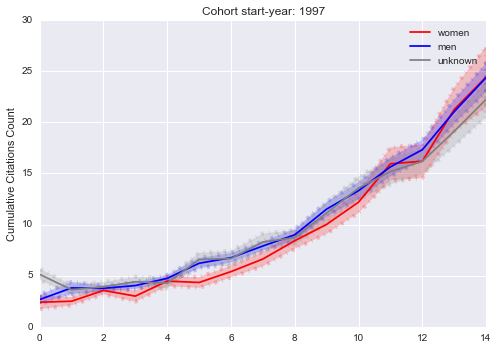

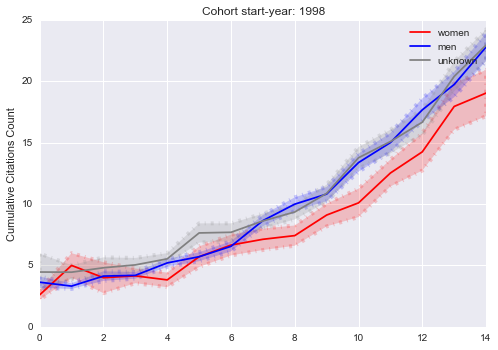

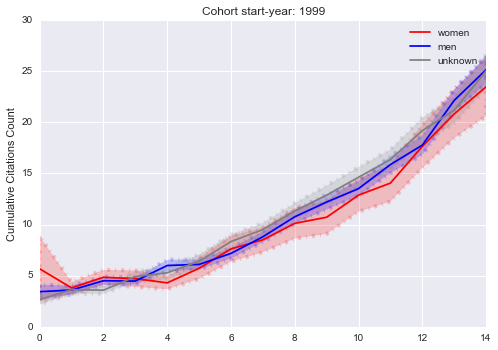

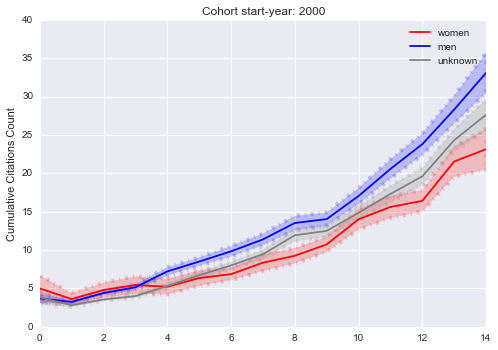

In [11]:
plot.plot_cohort_analysis_on(years, authorStartEndCareerData, groupCitationsByAuthorYearData, 
                             'cum_num_cit', 'Cumulative Citations Count')